In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import copy

import matplotlib.pyplot as plt

In [2]:
from Gan_convolutional import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed 

In [3]:
# check CUDA is available

if torch.cuda.is_available():

    torch.set_default_tensor_type(torch.cuda.FloatTensor)# Using GPU to train

    print("Training cuda:", torch.cuda.get_device_name(0))
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training cuda: NVIDIA GeForce GTX 1050 Ti


## Data preperation

In [4]:
#load data
data=[]
data_test=[]

#magnetization for original data
M_raw = []
M_raw_test = []

#there are 500 samples for each temperature, set 400 train data 100 test data
with h5py.File('../GAN/MC_2layers_T_BC.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']

        data.append(dataset[:][:400])
        
        data_test.append(dataset[:][400:500])

        M_raw.append(dataset[:].mean(axis=0).sum()/100)
        M_raw_test.append(dataset[:][400:500].mean(axis=0).sum()/100)

M_raw=np.array(M_raw)
M_raw_test=np.array(M_raw_test)
data=np.array(data)
data_test=np.array(data_test)

data=data.reshape(-1,2,10,10)
data_test=data_test.reshape(-1,2,10,10)

print('Train data shape {}'.format(data.shape))
print('Test data shape {}'.format(data_test.shape))

Train data shape (20000, 2, 10, 10)
Test data shape (5000, 2, 10, 10)


Temperature: 26 K
The two layers magnetization are [ 0.29604369 -0.0670828 ] respectively


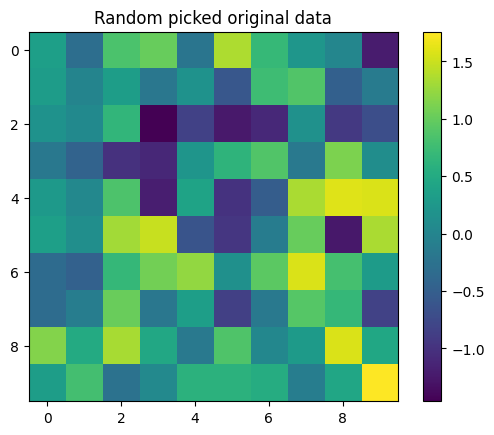

In [5]:
ii=np.random.randint(0,len(data))
print('Temperature: {} K'.format(int(ii/400)+1))
#original data plotting
plt.imshow(data[ii].sum(axis=0))#.cpu().detach().numpy()
plt.title('Random picked original data')
plt.colorbar()
print('The two layers magnetization are {} respectively'.format(data[ii].reshape(2,-1).sum(axis=1)/100))

In [6]:
data_num = 50
T = np.linspace(1,50,data_num)

#One hot encoding
One_hot_code=[]
for i in range(len(T)):
    for j in range(400):
        code=np.zeros(len(T))
        code[i]=1
        One_hot_code.append(code)
One_hot_code=np.array(One_hot_code)

#Transform the train data into [0,1],turn into tensor
data_set=(data+1)/2
data_set=torch.tensor(data_set).to(torch.float32)

#Transform the test data into [0,1],turn into tensor
data_test_set=(data_test+1)/2
data_test_set=torch.tensor(data_test_set).to(torch.float32)

#Transform the one hot coding to tensor
One_hot_code=torch.tensor(One_hot_code).to(torch.float32)

print(data_set.shape)
print(data_test_set.shape)
print(One_hot_code.shape)

#Consolidate data and One hot coding
data_all=[]
for i in range(20000):
    data_all.append([data_set[i], One_hot_code[i]])

torch.Size([20000, 2, 10, 10])
torch.Size([5000, 2, 10, 10])
torch.Size([20000, 50])


In [7]:
batch_size=250

data_loader = torch.utils.data.DataLoader(dataset=data_all,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          generator=torch.Generator(device = 'cuda'))

## Train Discriminator

In [17]:
%%time
epochs=240
v_dim = 2*10*10
h_dim = 500
z_dim = 100
learning_rate = 2e-4
class_num=len(T)

model_D = Discriminator( h_dim=h_dim,learning_rate=learning_rate, class_num=class_num)

model_D.to(device)# move defined model to cuda device

losses = []#record train loss

for epoch in np.arange(epochs):

    train_loss=0 
    

    for image_data, label_tensor in data_loader:

        image_data = image_data#.to(device)
        label_tensor = label_tensor#.to(device)

        # real_imgs = image_data.view(-1,v_dim)

        model_D.train(image_data, label_tensor, torch.ones(batch_size,1))# torch.cuda.FloatTensor([1.0])
        train_loss += model_D.Loss.detach().item()

        # fake data
        model_D.train(generate_random_image(batch_size).cuda(), generate_random_one_hot(batch_size, class_num), torch.zeros(batch_size,1))
        train_loss += model_D.Loss.detach().item()
    
    if (epoch+1)%20==0:
        print('Epoch: {}, loss: {}'.format(epoch+1, train_loss / (2*len(data_loader))))

    losses.append(train_loss / (2*len(data_loader)))
        

Epoch: 20, loss: 0.1134531395509839
Epoch: 40, loss: 0.032550791365792975
Epoch: 60, loss: 0.017372967438132037
Epoch: 80, loss: 0.009969761954926071
Epoch: 100, loss: 0.009421804369230813
Epoch: 120, loss: 0.00860426122253557
Epoch: 140, loss: 0.0068373526934692565
Epoch: 160, loss: 0.005655294410644274
Epoch: 180, loss: 0.005414412768107013
Epoch: 200, loss: 0.004506553201599673
Epoch: 220, loss: 0.00503111508648999
Epoch: 240, loss: 0.004764932145980083
Wall time: 13min 41s


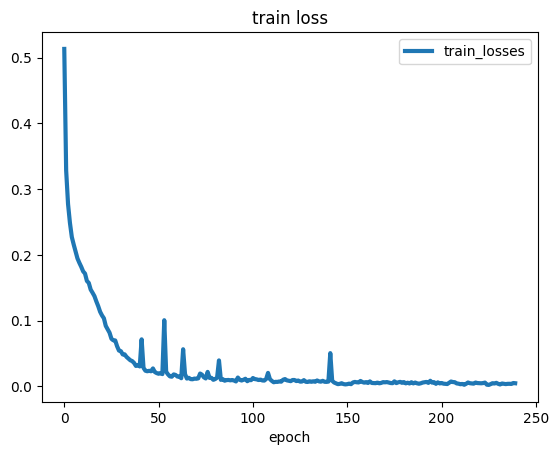

In [18]:
# plot discriminator loss
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, linewidth=3, linestyle='-', label='train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
# test discriminator to distinguish real and fake data
print('True')
for i in range(5): 
    A_label = np.random.randint(0,5000)

    image_data_tensor =data_test_set[A_label]

    One_hot_code_tensor=torch.zeros(class_num)
    One_hot_code_tensor[int(A_label/100)]=1.0
    print( model_D.forward( image_data_tensor.reshape(-1,2,10,10),One_hot_code_tensor.reshape(-1,50)).item() )

print('False')
for i in range(5):
    print( model_D.forward( generate_random_image(1).reshape(-1,2,10,10), generate_random_one_hot(1,50)).item() )


True
1.0
0.9024999737739563
0.9999951124191284
1.0
1.0
False
5.452512596093584e-06
5.249076480140502e-07
9.818791613103173e-11
6.68736788611568e-07
0.0004627910384442657


In [29]:
# # manually run discriminator to check it can tell real data from fake
# print('T')
# for i in range(5): 
  
#     A_label = np.random.randint(0,20000)
#     image_data_tensor =data_set[A_label]# celeba_dataset[random.randint(0,20000)]

#     One_hot_code_tensor=torch.zeros(class_num)
#     One_hot_code_tensor[int(A_label/400)]=1.0

#     print( model_D.forward( image_data_tensor.reshape(-1,2,10,10),One_hot_code_tensor.reshape(-1,50)).item() )
  
# print('F')
# for i in range(5):

#     print( model_D.forward( generate_random_image(1).reshape(-1,2,10,10), generate_random_one_hot(1,50)).item() )

## Train GAN

In [60]:
%%time 
v_dim = 2*10*10
z_dim = 100#25#20
h_dim=500
learning_rate=8e-6#1e-4
epochs = 250#300
class_num = len(T)

# create Discriminator and Generator

D_model = Discriminator( h_dim=h_dim, learning_rate=learning_rate, class_num=class_num)
D_model.to(device)
G_model = Generator(h_dim=h_dim+500, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)#+400
G_model.to(device)#+500

D_losses = []
G_losses = []

for epoch in range(epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:
        # image_data_tensor = torch.flatten(image_data_tensor)#, start_dim=1

        D_model.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        D_model.train(G_model.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1)) # torch.cuda.FloatTensor([0.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        G_model.train(D_model, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1) )#torch.cuda.FloatTensor([1.0])
        g_loss += G_model.Loss.detach().item()

    if (epoch+1)%20==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))

    D_losses.append(d_loss / (2*len(data_loader)))
    G_losses.append(g_loss / len(data_loader))

Epoch: 20, D_loss: 0.2484393293969333, G_loss: 2.1244483456015586
Epoch: 40, D_loss: 0.46679779030382634, G_loss: 1.498078453540802
Epoch: 60, D_loss: 0.5095862435176969, G_loss: 1.5022858083248138
Epoch: 80, D_loss: 0.5176394611597062, G_loss: 1.4826156795024872
Epoch: 100, D_loss: 0.5276061836630106, G_loss: 1.5853078946471215
Epoch: 120, D_loss: 0.5245706725865602, G_loss: 1.722258245944977
Epoch: 140, D_loss: 0.5275572834536433, G_loss: 1.691895854473114
Epoch: 160, D_loss: 0.5915454614907503, G_loss: 1.014159520715475
Epoch: 180, D_loss: 0.6722989812493324, G_loss: 0.7740513198077679
Epoch: 200, D_loss: 0.6999984506517649, G_loss: 0.7087213158607483
Epoch: 220, D_loss: 0.7068757880479097, G_loss: 0.6886317893862725
Epoch: 240, D_loss: 0.7023722503334284, G_loss: 0.6904434889554978
Wall time: 31min 2s


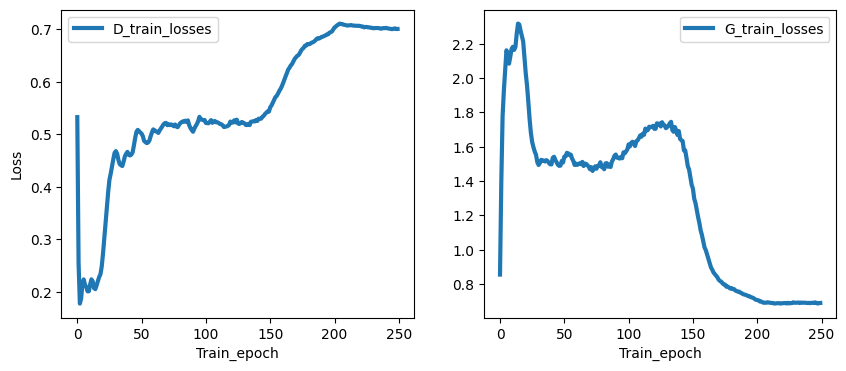

In [61]:
fig = plt.figure(figsize=(10,4))  

ax1=plt.subplot(121)
ax1.plot(np.arange(len(D_losses)), D_losses, linewidth=3, linestyle='-', label='D_train_losses')
# ax1.set_title('Total_loss')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax1=plt.subplot(122)
ax1.plot(np.arange(len(G_losses)), G_losses, linewidth=3, linestyle='-', label='G_train_losses')
# ax1.set_title('Total_loss')
ax1.set_xlabel('Train_epoch')
# ax1.set_ylabel('Loss')
ax1.legend()

plt.show()

## Run trained Generator

[-0.7970178  0.8351151]


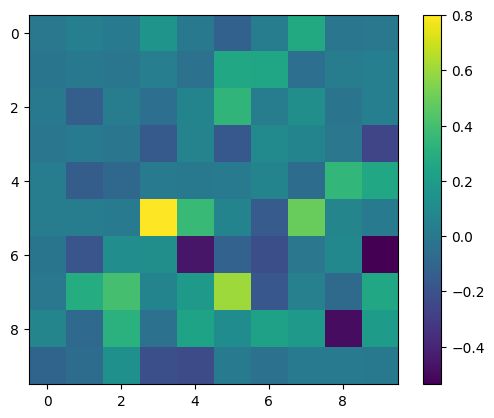

In [62]:
Temperature=10
Code=torch.zeros(50)
Code[Temperature-1]=1.0
output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
img = output.detach().cpu().numpy().reshape(2,10,10)
generated_img=img*2-1
plt.imshow(generated_img.sum(axis=0))
plt.colorbar()

print(generated_img.sum(axis=1).sum(axis=1)/100)

## Create data for magnetic measurement

In [63]:
M_generated=[]
Susceptibility = []
sample_num=400
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    
    cal_M = 0
    cal_M_2=0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1
        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2
    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num


    M_generated.append(cal_M.copy())
    Susceptibility.append((1/(ii+1))*(cal_M_2-cal_M**2))

M_generated=np.array(M_generated)
Susceptibility=np.array(Susceptibility)

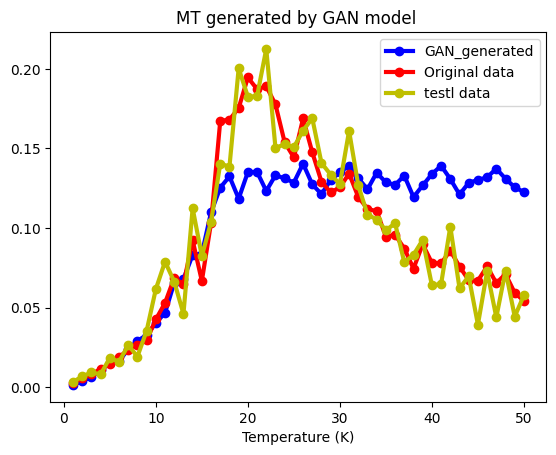

In [64]:
plt.plot(T, M_generated,'bo-',markersize=6,lw=3,label='GAN_generated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

Text(0.5, 0, 'Temperature (K)')

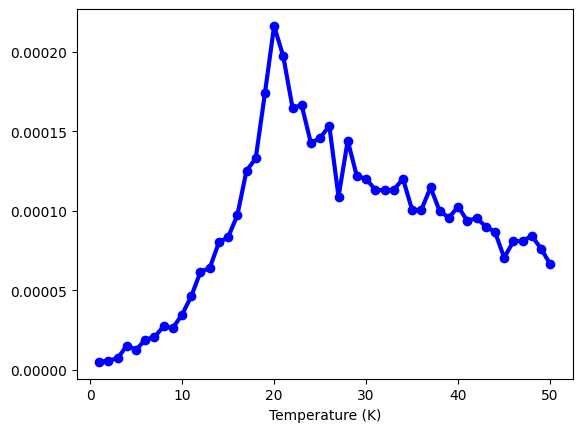

In [65]:
plt.plot(T, reSusceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')

## Model saving and reloading

In [15]:
torch.save(G_model,"Trained_model_saving/newG_convolutional_z100_h5001000_Ir1em5.pth")
torch.save(D_model,"Trained_model_saving/newD_convolutional_z100_h5001000_Ir1em5.pth")# saving the whole model

In [16]:
reloaded_G=torch.load("Trained_model_saving/newG_convolutional_z100_h5001000_Ir1em5.pth")
reloaded_D=torch.load("Trained_model_saving/newD_convolutional_z100_h5001000_Ir1em5.pth")

## Continue Training

In [70]:
%%time 

re_epochs = 30#300
class_num = len(T)
reD_losses = []
reG_losses = []

for epoch in range(re_epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:
        # image_data_tensor = torch.flatten(image_data_tensor)#, start_dim=1

        reloaded_D.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += reloaded_D.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        reloaded_D.train(reloaded_G.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1)) # torch.cuda.FloatTensor([0.0])
        d_loss += reloaded_D.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        reloaded_G.train(reloaded_D, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1) )#torch.cuda.FloatTensor([1.0])
        g_loss += reloaded_G.Loss.detach().item()

    if (epoch+1)%5==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))

    reD_losses.append(d_loss / (2*len(data_loader)))
    reG_losses.append(g_loss / len(data_loader))

Epoch: 5, D_loss: 0.6941428620368242, G_loss: 0.6938919611275196
Epoch: 10, D_loss: 0.694614489749074, G_loss: 0.6881599962711334
Epoch: 15, D_loss: 0.6952279023826122, G_loss: 0.6920770712196826
Epoch: 20, D_loss: 0.6946448370814323, G_loss: 0.6943154409527779
Epoch: 25, D_loss: 0.695797074586153, G_loss: 0.6897207476198673
Epoch: 30, D_loss: 0.694323843717575, G_loss: 0.6943236708641052
Wall time: 4min 58s


In [71]:
M_regenerated=[]
reSusceptibility = []

sample_num=400
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    cal_M = 0
    cal_M_2=0

    for jj in range(sample_num):
        output=reloaded_G.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1

        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2


    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num

    M_regenerated.append(cal_M.copy())
    reSusceptibility.append(((1/(ii+1))*(cal_M_2-cal_M**2)))


M_regenerated=np.array(M_regenerated)
reSusceptibility=np.array(reSusceptibility)

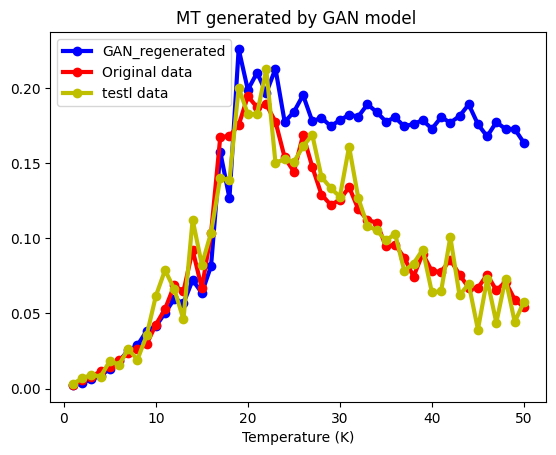

In [72]:
plt.plot(T, M_regenerated,'bo-',markersize=6,lw=3,label='GAN_regenerated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

Text(0.5, 0, 'Temperature (K)')

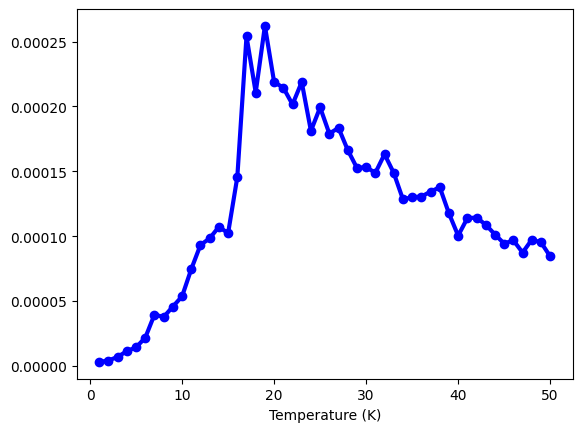

In [73]:
plt.plot(T, reSusceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')